In [ ]:
import os 
import glob

import pandas as pd
import numpy as np
import random

import cv2

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2, MobileNetV2
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
import seaborn as sns

In [ ]:
data_path = 'data/cell-images-for-detecting-malaria/cell_images'

In [ ]:
label = []
path = []
for dirname, _,filenames in os.walk(data_path):
    for filename in filenames:
        if os.path.splitext(filename)[1]=='.png':
            if dirname.split()[-1]!='GT':          
                label.append(os.path.split(dirname)[1])
                path.append(os.path.join(dirname,filename))

data = pd.DataFrame(columns=['path','label'])
data['path'] = path
data['label'] = label

In [ ]:
data.head()

,path,label
0,../input/cell-images-for-detecting-malaria/cel...,Uninfected
1,../input/cell-images-for-detecting-malaria/cel...,Uninfected
2,../input/cell-images-for-detecting-malaria/cel...,Uninfected
3,../input/cell-images-for-detecting-malaria/cel...,Uninfected
4,../input/cell-images-for-detecting-malaria/cel...,Uninfected


In [ ]:
data['label'] = data['label'].astype('category')

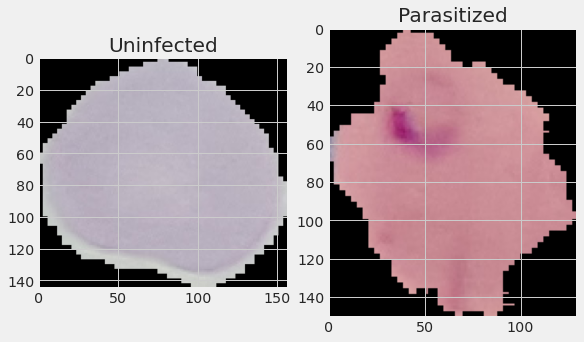

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,8), constrained_layout=True)
ax=ax.flatten()
j=0
    
for i in data['label'].unique():
    
    ax[j].imshow(plt.imread(data[data['label']==i].iloc[0,0]))
    ax[j].set_title(i)
    j=j+1

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=2021)

In [ ]:
print(train.shape)
print(test.shape)

(44092, 2)
(11024, 2)


In [ ]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function= preprocess_input)

x_train = train_gen.flow_from_dataframe(dataframe=train, x_col='path', y_col='label',
                                           class_mode='categorical', subset='training', 
                                           color_mode='rgb', batch_size=32, shuffle=False)

x_val = train_gen.flow_from_dataframe(dataframe=train, x_col='path', y_col='label',
                                         class_mode='categorical', subset='validation', 
                                         color_mode='rgb', batch_size=32, shuffle=False)

x_test = test_gen.flow_from_dataframe(dataframe=test, x_col='path', y_col='label',
                                         class_mode='categorical', color_mode='rgb', 
                                         batch_size=32, shuffle=False)

Found 35274 validated image filenames belonging to 2 classes.
Found 8818 validated image filenames belonging to 2 classes.
Found 11024 validated image filenames belonging to 2 classes.


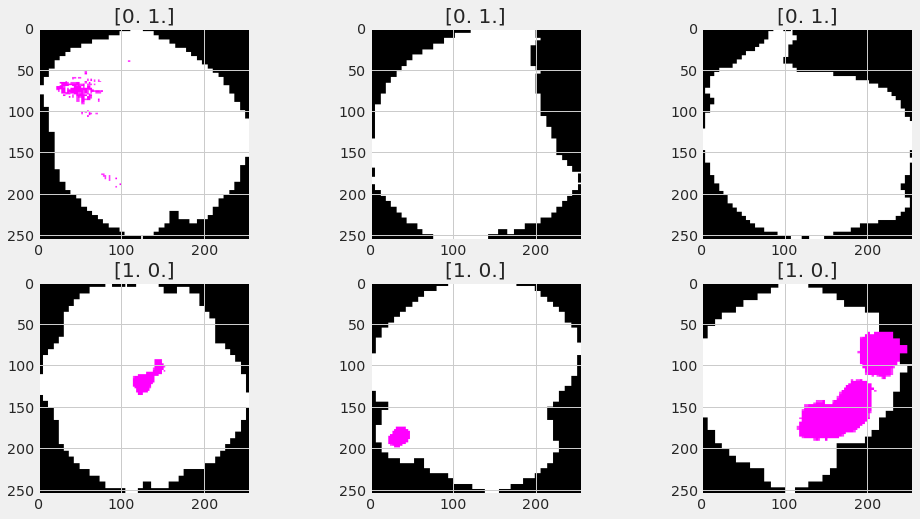

In [ ]:
# fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
# ax = ax.flatten()
# j = 0
# for _ in range(6):
#     img, label = x_test.next()
#     ax[j].imshow(img[0],);
#     ax[j].set_title(label[0])
#     j=j+1

In [ ]:
x_test[0][0].shape

(32, 256, 256, 3)

In [ ]:
image_shape=(224,224,3)

In [ ]:
early = EarlyStopping(monitor='val_loss',patience=5)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

In [ ]:
pre_trained= MobileNetV2(include_top=False, pooling='avg', input_shape=image_shape)

pre_trained.trainable=False

inp_model = pre_trained.input
x = Dense(128, activation='relu')(pre_trained.output)
x = Dense(128, activation='relu')(x)

output = Dense(2, activation='softmax')(x)
model = Model(inputs=inp_model, outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

results = model.fit(x_train,epochs=10, validation_data=x_val, callbacks=[early, reduce])

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/10
1103/1103 [==============================] - 348s 311ms/step - loss: 0.2769 - accuracy: 0.8835 - val_loss: 0.2002 - val_accuracy: 0.9242
Epoch 2/10
1103/1103 [==============================] - 135s 122ms/step - loss: 0.2056 - accuracy: 0.9169 - val_loss: 0.1947 - val_accuracy: 0.9218
Epoch 3/10
1103/1103 [==============================] - 136s 123ms/step - loss: 0.1897 - accuracy: 0.9251 - val_loss: 0.1848 - val_accuracy: 0.9265
Epoch 4/10
1103/1103 [==============================] - 136s 123ms/step - loss: 0.1744 - accuracy: 0.9309 - val_loss: 0.1819 - val_accuracy: 0.9290
Epoch 5/10
1103/1103 [==============================] - 137s 124ms/step - loss: 0.1622 - accuracy: 0.9367 - val_loss: 0.1924 - val_accuracy: 0.9232
Epoch 6/10
1103/1103 [==============================] - 135s 122ms/step - loss: 0.1471 - accuracy: 0.9405 - val_loss: 0.1874 - val_accuracy: 0.9258
Epoch 8/10
1103/1103 [===========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1103/1103 [==============================] - 135s 123ms/step - loss: 0.1053 - accuracy: 0.9599 - val_loss: 0.1480 - val_accuracy: 0.9425


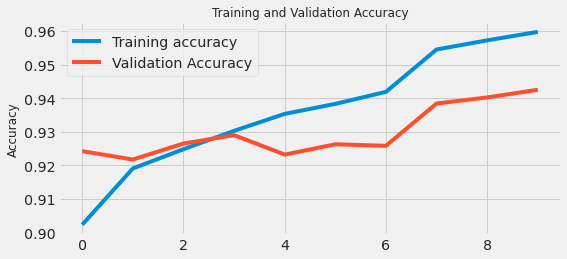

In [ ]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc,label="Training accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.show()

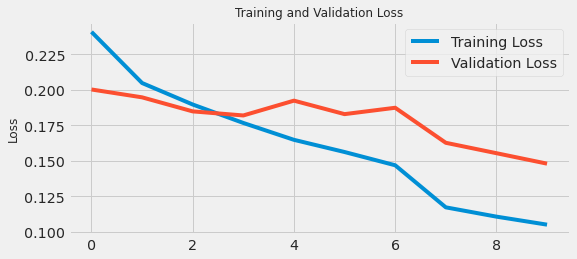

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(results.history['loss'], label="Training Loss")
plt.plot(results.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss",fontsize=12)
plt.show()

In [ ]:
model.evaluate(x_test, verbose=1)

345/345 [==============================] - 83s 241ms/step - loss: 0.1433 - accuracy: 0.9435


[0.1432742029428482, 0.9434869289398193]